In [336]:
import numpy as np
import random
import pandas as pd
import math
import matplotlib.pyplot as plt 
from tqdm import tqdm_notebook as tqdm
from scipy import integrate
import collections

In [331]:
#Helper Functions for the Q Learning Networks
def rewards(current_price, shares_buying):
    new_price = new_position(shares_buying, current_price)
    reward = shares_buying * (new_price)
    return reward

def quadratic_rewards(current_price, shares_buying):
    new_price = generate_quadratic(shares_buying, current_price)
    reward = shares_buying * new_price
    return reward 

def new_position(position, price):
    new_price = price + np.random.normal(0, 0.1) - (0.05*position)
    #new_price = price + np.random.normal(0, 0.1) - (0.005*math.pow(position,2) + 0.00002*position)
    return np.round(new_price)

def generate_quadratic(position, price):
    new_price = price + np.random.normal(0, 0.1) - (0.00005*math.pow(position,2) + 0.0002*position)
    return np.round(new_price)

def generate_price(price):
    new_price = price + np.random.uniform(-2, 2)
    return np.round(new_price)

In [56]:
#Helper Functions for the Q Learning Networks
def actions_generate(shares_remaining, time, t):
    actions_list = []
    for j in range(0, 11):
        if actions(j) <= shares_remaining:
            actions_list.append(j)
    return actions_list

In [57]:
#Helper Functions for the Q Learning Networks
def generate_q(price, shares_remaining, time):
    val = 0
    state = (time, price, shares_remaining)
    if state in Q_table.index:
        val = max(Q_table.loc[state])
    return val

In [666]:
Q_table = pd.DataFrame(columns=["Time", "Price", "Shares Remaining", 0, 100])
Q_table = Q_table.set_index(["Time", "Price", "Shares Remaining"])
visits = {}
transaction_costs = []
def DQN_Quadratic(time, shares):
    epoch = 0
    count = 0
    alpha = 0.1
    epsilon = 1
    Q_table_check = pd.DataFrame()
    condition = True
    for x in tqdm(range(75000)):
        Q_table_check = Q_table.copy()
        total_reward = 0
        synthetic_prices = [100]
        total_shares_inventory = shares
        for t in range(1, time + 1):
            current_price = synthetic_prices[-1]
            current_state = (t, current_price, total_shares_inventory)
            if current_state not in Q_table.index:
                Q_table.loc[current_state] = 0
            if t == time:
                shares_buying = total_shares_inventory
                if shares_buying not in Q_table.columns:
                    Q_table[shares_buying] = 0
                if shares_buying != 0:
                    reward_val = quadratic_rewards(current_price, shares_buying)
                else:
                    reward_val = 0
                Q_val = (1 - alpha) * Q_table.loc[current_state, shares_buying] + alpha * (reward_val)
                new_price = generate_price(current_price)
                synthetic_prices.append(new_price)
                Q_table.loc[current_state, shares_buying] = Q_val
            else:
                if random.random() < (epsilon - count*0.001):
                    shares_buying = random.randrange(0, total_shares_inventory + 1, 50)
                else:
                    Q_copy = Q_table.copy()
                    columns_drop = []
                    for i in Q_copy.columns:
                        if i > total_shares_inventory:
                            columns_drop.append(i)
                    Q_copy = Q_copy.drop(columns_drop, axis = 1)
                    value = max(Q_copy.loc[current_state].values)
                    shares_buying = Q_copy.columns[(Q_copy == value).loc[current_state]][0]
                if shares_buying not in Q_table.columns:
                    Q_table[shares_buying] = 0
                if shares_buying != 0:
                    reward_val = quadratic_rewards(current_price, shares_buying)
                else:
                    reward_val = 0
                new_price = generate_price(current_price)
                synthetic_prices.append(new_price)
                future_q = generate_q(new_price, total_shares_inventory - shares_buying, t + 1)
                Q_val = (1 - alpha) * Q_table.loc[current_state, shares_buying] + alpha * (reward_val + future_q)
                Q_table.loc[current_state, shares_buying] = Q_val
                if t == 1:
                    transaction_costs.append(Q_table.reindex(sorted(Q_table.columns), axis=1).loc[1])
            build_tuple = (*current_state, shares_buying)
            if build_tuple not in visits:
                visits[build_tuple] = 0
            visits[build_tuple] = visits[build_tuple] + 1
            total_shares_inventory = total_shares_inventory - shares_buying
        epoch = epoch + 1
        #print('Epoch: ' + str(epoch))
    return Q_table

In [668]:
DQN_Quadratic(4, 400)

,,,0,100,50,350,150,250,200,300,400
Time,Price,Shares Remaining,,,,,,,,,
1,100.0,400,39563.6,39730.6,39656.707049,37923.652431,39768.485507,39203.261019,39549.636532,38638.950196,36800.000000
2,101.0,350,33645.8,35026.7,35053.023593,33250.000000,35109.945112,34593.076924,34869.567390,33959.079359,0.000000
3,103.0,350,21810.3,29055.5,17815.917375,26183.328962,26033.979328,29893.637768,26223.911135,28811.596865,0.000000
4,101.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,101.0,400,34845.1,40004.9,38695.706308,38305.684009,40042.015202,39627.929996,39802.110919,38919.634541,37200.000000
3,101.0,400,17280.5,26349.4,30347.257960,27497.827216,34727.252984,27893.832527,33616.112064,33030.056536,32677.348449
4,101.0,250,0,0,0.000000,0.000000,0.000000,24500.000000,0.000000,0.000000,0.000000
2,102.0,400,31743.8,39310,35586.625907,38703.180882,39597.407749,39989.891317,39987.927631,39350.540664,37599.901650
3,104.0,350,6057.16,6472.16,13957.335815,6517.000000,7350.689165,13356.634873,11071.867123,9471.306570,0.000000


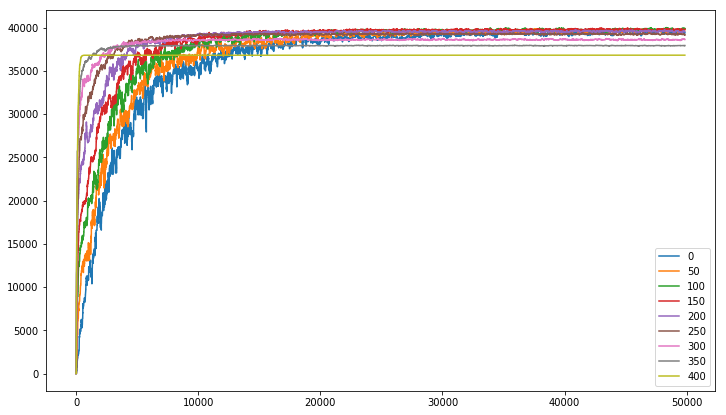

In [672]:
plt.figure(figsize=(12,7))
for i in transaction_cost.columns:
    plt.plot(list(transaction_cost[i]), label = str(i))
    plt.legend()
plt.show()

In [365]:
Q_table = pd.DataFrame(columns=["Time", "Price", "Shares Remaining", 0, 100])
Q_table = Q_table.set_index(["Time", "Price", "Shares Remaining"])
visits = {}
transaction_costs = []
def DQN(time, shares):
    epoch = 0
    count = 0
    alpha = 0.1
    epsilon = 1
    for x in tqdm(range(10000)):
        Q_table_check = Q_table.copy()
        total_reward = 0
        synthetic_prices = [100]
        total_shares_inventory = shares
        for t in range(1, time + 1):
            current_price = synthetic_prices[-1]
            current_state = (t, current_price, total_shares_inventory)
            if current_state not in Q_table.index:
                Q_table.loc[current_state] = 0
            if t == time:
                shares_buying = total_shares_inventory
            else:
                if random.random() < (epsilon - count*0.00001):
                    shares_buying = random.randrange(0, total_shares_inventory + 1, 50)
                else:
                    Q_copy = Q_table.copy()
                    columns_drop = []
                    for i in Q_copy.columns:
                        if i > total_shares_inventory:
                            columns_drop.append(i)
                    Q_copy = Q_copy.drop(columns_drop, axis = 1)
                    value = max(Q_copy.loc[current_state].values)
                    shares_buying = Q_copy.columns[(Q_copy == value).loc[current_state]][0]
            if shares_buying not in Q_table.columns:
                Q_table[shares_buying] = 0
            if shares_buying != 0:
                reward_val = rewards(current_price, shares_buying)
            else:
                reward_val = 0
            new_price = new_position(shares_buying, current_price)
            synthetic_prices.append(new_price)
            future_q = generate_q(new_price, total_shares_inventory - shares_buying, t + 1)
            Q_val = (1 - alpha) * Q_table.loc[current_state, shares_buying] + alpha * (reward_val + future_q)
            Q_table.loc[current_state, shares_buying] = Q_val
            if t == 1:
                transaction_costs.append(Q_table.reindex(sorted(Q_table.columns), axis=1).loc[1])
            build_tuple = (*current_state, shares_buying)
            if build_tuple not in visits:
                visits[build_tuple] = 0
            visits[build_tuple] = visits[build_tuple] + 1
            total_shares_inventory = total_shares_inventory - shares_buying
        epoch = epoch + 1
        #print('Epoch: ' + str(epoch))
    return Q_table.reindex(sorted(Q_table.columns), axis=1).sort_index(by = "Time")

In [391]:
Q_table1 = Q_table.copy()
Q_table1 = Q_table1.reset_index()

In [393]:
Q_table0 = Q_table1.copy()[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 300)]
Q_table2 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 100)]
Q_table3 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 100/3)]

In [407]:
pd.concat([Q_table0, Q_table2.drop(Q_table2.tail(1).index), Q_table3], ignore_index=True)

,Time,Price,Shares Remaining,0,100,50,250,150,200,300
0,1,100.0,300,26582.5,27000,26921.323103,26121.584913,26882.301628,26619.274044,25500.0
1,2,95.0,200,17000,17500,17381.717060,0.000000,17419.763750,17000.000000,0.0
2,3,91.0,100,0,8600,0.000000,0.000000,0.000000,0.000000,0.0
3,3,90.0,100,0,8500,0.000000,0.000000,0.000000,0.000000,0.0
4,3,89.0,100,0,8400,0.000000,0.000000,0.000000,0.000000,0.0


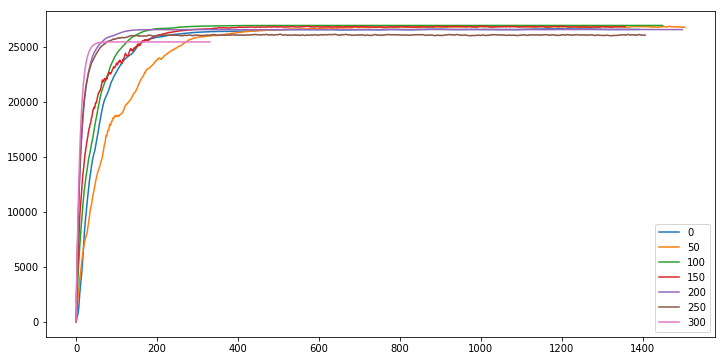

In [341]:
#In the graph below, we see that all the states converge. It is hard to see, but 100 converges at the highest value.
plt.figure(figsize=(12,6))
for i in transaction_cost.columns:
    plt.plot(list(collections.OrderedDict.fromkeys(transaction_cost[i])), label = str(i))
    plt.legend()
plt.show()

In [677]:
#Transient Rewards
def transient_rewards(current_price, shares_buying, shares_buying_list, noise, time):
    sum_shares = 0
    #print(shares_buying_list)
    for i in range(1, time+1):
        x2 = 0.5*shares_buying_list[i-1]*math.exp((-0.25)*(time-i))
        sum_shares += x2
    new_price = current_price + sum(noise) - sum_shares
    reward = shares_buying*(new_price)
    return (reward, np.round(new_price, 0))

#Expected Total Reward
total_rewards = []
for j in range(50000):
    shares_buying = [30, 20, 20, 20, 30]
    noise = [np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1)]
    synthetic_price = [100]
    rewards = []
    for i in range(0, 5):
        reward = transient_rewards(100, shares_buying[i], shares_buying[:i+1], noise[:i+1], i+1)
        rewards.append(reward[0])
        synthetic_price.append(reward[1])
    total_rewards.append(sum(rewards))
np.mean(total_rewards)

8787.004003306214

In [524]:
#Expected Total Reward for Splitting Shares Evenly
total_rewards = []
for i in range(0, 50000):
    shares_buying = [120/5]*5
    noise = [np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1)]
    synthetic_price = [100]
    rewards = []
    for i in range(0, 5):
        reward = transient_rewards(100, shares_buying[i], shares_buying[:i+1], noise[:i+1], i+1)
        rewards.append(reward[0])
        synthetic_price.append(reward[1])
    total_rewards.append(sum(rewards))
np.mean(total_rewards)

8760.873074798883

In [525]:
total_rewards = []
for i in range(0, 50000):
    shares_buying = [120, 0, 0, 0, 0]
    noise = [np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1), np.random.normal(0, 0.1)]
    synthetic_price = [100]
    rewards = []
    for i in range(0, 5):
        reward = transient_rewards(100, shares_buying[i], shares_buying[:i+1], noise[:i+1], i+1)
        rewards.append(reward[0])
        synthetic_price.append(reward[1])
    total_rewards.append(sum(rewards))
np.mean(total_rewards)

4800.0264697556695

Here we see that the optimal strategy for the transient is not evenly split. The best option is to by 300,then 200, then 200 again, then 200, and then 300. We also see that buying everything at once is a poor strategy as we lose out on a lot of expected reward.

In [673]:
Q_table = pd.DataFrame(columns=["Time", "Price", "Shares Remaining", 0, 100])
Q_table = Q_table.set_index(["Time", "Price", "Shares Remaining"])
visits = {}
transaction_costs = []
listofpaths = []
def DQN_transient(time, shares):
    epoch = 0
    count = 0
    alpha = 0.1
    Q_table_check = pd.DataFrame()
    condition = True
    epsilon = 1
    for x in tqdm(range(100000)):
        #Q_table_check = Q_table.copy()
        total_reward = 0
        synthetic_prices = [100]
        noise = []
        total_shares_inventory = shares
        shares_buying_list = []
        for t in range(1, time+1):
            noise.append(np.random.normal(0, 0.1))
            current_price = synthetic_prices[0]
            state_price = synthetic_prices[-1]
            current_state = (t, state_price, total_shares_inventory)
            if current_state not in Q_table.index:
                Q_table.loc[current_state] = 0
            if t == time:
                shares_buying = total_shares_inventory
            else:
                if random.random() < (epsilon):
                    shares_buying = random.randrange(0, total_shares_inventory + 1, 10)
                else:
                    Q_copy = Q_table.copy()
                    columns_drop = []
                    for i in Q_copy.columns:
                        if i > total_shares_inventory:
                            columns_drop.append(i)
                    Q_copy = Q_copy.drop(columns_drop, axis = 1)
                    value = max(Q_copy.loc[current_state].values)
                    shares_buying = Q_copy.columns[(Q_copy == value).loc[current_state]][0]
            shares_buying_list.append(shares_buying)
            if shares_buying not in Q_table.columns:
                Q_table[shares_buying] = 0
            transient = transient_rewards(current_price, shares_buying, shares_buying_list, noise, t)
            new_price = transient[1]
            #print(new_price)
            synthetic_prices.append(new_price)
            future_q = generate_q(new_price, total_shares_inventory - shares_buying, t + 1)
            Q_val = (1 - alpha) * Q_table.loc[current_state, shares_buying] + alpha * (transient[0] + future_q)
            Q_table.loc[current_state, shares_buying] = Q_val
            total_shares_inventory = total_shares_inventory - shares_buying
            if t == 1:
                transaction_costs.append(Q_table.reindex(sorted(Q_table.columns), axis=1).loc[1])
        listofpaths.append(shares_buying_list)
        build_tuple = (*current_state, shares_buying)
        if build_tuple not in visits:
            visits[build_tuple] = 0
        visits[build_tuple] = visits[build_tuple] + 1
        count += 1 
    return Q_table

In [675]:
DQN_transient(5, 120)

,,,0,100,10,40,80,120,20,60,70,30,50,90,110
Time,Price,Shares Remaining,,,,,,,,,,,,,
1,100.0,120,8145.88,6437.85,8496.098090,8711.042551,7596.587058,4797.608973,8644.249985,8338.482499,8012.481489,8727.750233,8561.760212,7080.623173,5690.753200
2,100.0,120,6353.37,6330.24,6899.464817,8142.336671,7392.511576,4797.752654,7495.644240,8029.431993,7780.489588,7851.376326,8145.938616,6924.581516,5641.057078
3,50.0,20,1327.54,0,1244.575421,0.000000,0.000000,0.000000,1021.451635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,61.0,20,1327.99,0,1322.331241,0.000000,0.000000,0.000000,1190.918008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,64.0,10,0,0,669.510804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80.0,80,5238.3,0,5505.042688,5265.135156,3552.330460,0.000000,5510.270712,4628.102945,4175.290715,5446.105750,5013.631025,0.000000,0.000000
3,44.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,57.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,66.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [681]:
Q_table.copy().reindex(sorted(Q_table.columns), axis=1).sort_index(by = "Time")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


0            10           20           30   \
Time Price Shares Remaining                                                   
1    100.0 120               8145.88  8496.098090  8644.249985  8727.750233   
2    45.0  10                742.202   521.492933     0.000000     0.000000   
     95.0  110               6301.04  6823.816645  7354.796863  7473.441992   
     65.0  50                3462.59  3449.907201  3343.039042  3134.019597   
     50.0  20                1438.66  1303.006970  1020.553056     0.000000   
     55.0  30                2128.88  2029.602240  1838.052101  1499.052754   
     75.0  70                 4747.1  4811.717847  4798.342731  4683.331901   
     85.0  90                5762.15  6109.095120  6178.061937  6175.859058   
     70.0  60                4094.95  4138.043917  4075.937733  3922.267546   
     90.0  100               6280.76  6566.631647  6820.145914  6844.478989   
     60.0  40                2796.14  2749.223448  2592.446129  2345.860945   
     40.0  0                       0     0.000000     0.000000     0.000000   
     100.0 120               6353.37  6899.464817  7495.644240  7851.376326   
     80.0  80                 5238.3  5505.042688  5510.270712  5446.105750   
3    59.0  40                 203.74     0.000000     0.000000     0.000000   
     81.0  70                3473.74  4502.215956  4758.438361  4704.678162   
     60.0  40                2587.36  2594.358762  2475.893765  2286.899347   
     57.0  30                2013.49  1954.453963  1821.919690  1549.252238   
     72.0  60                 3794.3  3915.121040  3926.250647  3838.601560   
     79.0  70                3259.68  4423.282265  4704.623838  4648.688054   
     43.0  0                       0     0.000000     0.000000     0.000000   
     63.0  40                2644.74  2662.751049  2557.471721  2376.890886   
     66.0  40                2706.12  2724.843348  2624.624401  2449.466053   
     77.0  60                3591.86  4095.459608  4101.261115  4017.923164   
     63.0  30                2090.61  2051.442794  1932.021039  1678.729478   
     53.0  20                1358.52  1284.005438  1071.000223     0.000000   
     69.0  50                3286.49  3349.811782  3313.645842  3157.466717   
     65.0  40                2687.22  2707.811531  2603.511123  2421.683475   
     92.0  100               3031.13  4931.954651  5941.696154  6011.581012   
     87.0  90                2994.38  4877.677323  5411.024875  5691.833621   
...                              ...          ...          ...          ...   
5    71.0  20                      0     0.000000  1346.754296     0.000000   
     68.0  10                      0   700.353370     0.000000     0.000000   
     55.0  0                       0     0.000000     0.000000     0.000000   
     64.0  20                      0     0.000000  1239.688185     0.000000   
     74.0  30                      0     0.000000     0.000000  1941.595192   
     52.0  10                      0   576.014262     0.000000     0.000000   
     78.0  30                      0     0.000000     0.000000  2038.417612   
     60.0  0                       0     0.000000     0.000000     0.000000   
     62.0  10                      0   654.396562     0.000000     0.000000   
     69.0  30                      0     0.000000     0.000000  1827.304030   
     60.0  10                      0   638.525638     0.000000     0.000000   
     71.0  10                      0   724.278101     0.000000     0.000000   
     76.0  40                      0     0.000000     0.000000     0.000000   
     57.0  20                      0     0.000000  1123.942856     0.000000   
     42.0  0                       0     0.000000     0.000000     0.000000   
     56.0  10                      0   607.547022     0.000000     0.000000   
     65.0  10                      0   677.938993     0.000000     0.000000   
     77.0  30                      0     0.000000     0.000000  2011.259646   
    

In [652]:
#here we see that the highest reward is 30, then 20, then 20, and so forth. 
#Q_table = Q_table.reindex(sorted(Q_table.columns), axis=1).sort_index(by = "Time")
Q_table1 = Q_table.copy().reindex(sorted(Q_table.columns), axis=1).sort_index(by = "Time")
Q_table1 = Q_table1.reset_index()
Q_table0 = Q_table1.copy()[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 120)]
Q_table2 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 45)]
Q_table3 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 70/3)]
Q_table4 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 50/4)]
Q_table5 = Q_table1[(Q_table1.copy()['Shares Remaining']/Q_table1.copy()['Time'] == 30/5)]
pd.concat([Q_table0, Q_table2, Q_table3.drop(Q_table3.index[1:]), Q_table4, Q_table5.drop(Q_table5.index[1:])], ignore_index=True)



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


,Time,Price,Shares Remaining,0,10,20,30,40,50,60,70,80,90,100,110,120
0,1,100.0,120,8085.67,8443.367802,8651.581787,8731.437146,8693.682231,8554.748078,8324.355323,8005.980531,7594.720425,7076.521514,6440.05,5693.9941,4795.868101
1,2,85.0,90,5607.22,6057.311949,6181.504732,6156.419139,6049.493857,5831.490083,5524.789218,5097.388817,4571.230284,3899.968205,0,0.0000,0.000000
2,3,78.0,70,3609.85,4433.490700,4622.656930,4572.956638,4449.941475,4183.387413,3846.550229,3365.852903,0.000000,0.000000,0,0.0000,0.000000
3,4,74.0,50,2952.68,3150.744872,3198.214826,3066.233041,3019.343324,2717.479366,0.000000,0.000000,0.000000,0.000000,0,0.0000,0.000000
4,5,77.0,30,0,0.000000,0.000000,2011.722016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0000,0.000000


In [ ]:
transaction_cost = transaction_costs[0]
for i in tqdm(range(1, len(transaction_costs))):
    transaction_cost = transaction_cost.append(transaction_costs[i]).fillna(0)
plt.figure(figsize=(12,7))
for i in transaction_cost.columns:
    plt.plot(list(collections.OrderedDict.fromkeys(transaction_cost[i])), label = str(i))
    plt.legend()
plt.show()

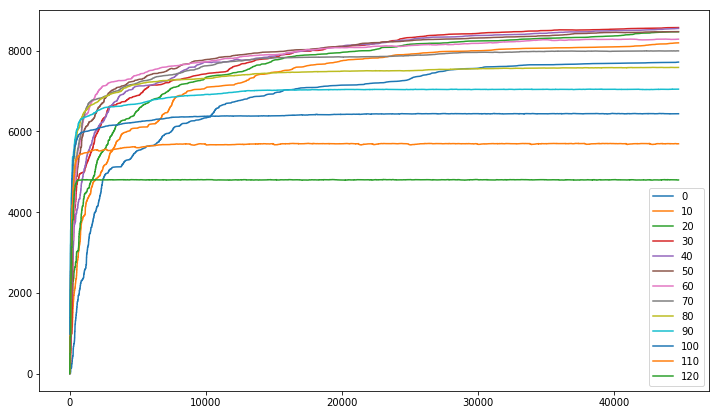

In [665]:
plt.figure(figsize=(12,7))
for i in transaction_cost.columns:
    plt.plot(list(transaction_cost[i]), label = str(i))
    plt.legend()
plt.show()